In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

## Data exploration

> Before diving in the huge comments dataset containing more than 1 billions comments we will go through the 2 large dataset containing information about number of comments per author and number of comments per videos 

In [3]:
# Load the 2 datasets
num_comments = pd.read_csv("data/num_comments.tsv", sep="\t")
num_comments_authors = pd.read_csv("data/num_comments_authors.tsv", sep="\t")

### 1. Video comments dataset

In [4]:
num_comments.head()

,display_id,num_comms
0,SBqSc91Hn9g,0.0
1,UuugEl86ESY,0.0
2,oB4c-yvnbjs,48.0
3,ZaV-gTCMV8E,6.0
4,cGvL7AvMfM0,5.0


In [5]:
num_comments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72924794 entries, 0 to 72924793
Data columns (total 2 columns):
 #   Column      Dtype  
---  ------      -----  
 0   display_id  object 
 1   num_comms   float64
dtypes: float64(1), object(1)
memory usage: 1.1+ GB


In [6]:
num_comments.describe()

,num_comms
count,7.292479e+07
mean,1.217165e+02
std,1.343391e+03
min,0.000000e+00
25%,0.000000e+00
50%,5.000000e+00
75%,3.900000e+01
max,1.125155e+06


> First we note that we have indeed a large dataset with more than 72 millions entries corresponding to the 72,924,794 videos created between 2005-05-24 to 2019-11-20. We may add additionnal this comments information later to the video metadat to enhance our analysis. But for the moment we can spot that these numms of comments are distributed following a heavy taile distribution as most of the mass is contains between 0 comments and 39 comments, pretty low in comparison to the max value of 1.125155e+06.

-  Lets visualy look at this distribution using the ccdf on log scale of our data. 

In [7]:
sample_df = num_comments.sample(int(2e+06))

/var/folders/gx/b0gl84xd4rjflbpgs2bhddcc0000gp/T/ipykernel_58868/2609893468.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.log10(num_comments.num_comms + 1), kde=False,


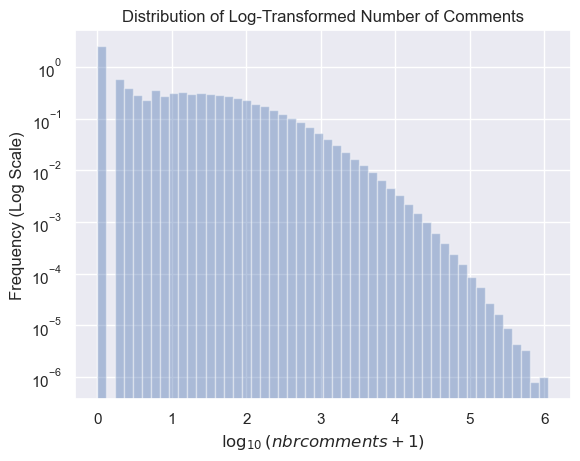

In [8]:
# Simple log log hist plot
kwargs = {'cumulative': False}
sns.distplot(np.log10(num_comments.num_comms + 1), kde=False, 
             kde_kws=kwargs, norm_hist=True)
plt.title("Distribution of Log-Transformed Number of Comments")
plt.xlabel(r'$\log_{10}(nbrcomments + 1)$')
plt.ylabel("Frequency (Log Scale)")
plt.yscale('log')
plt.show()

> Looking at the distribution of the comments per videos we can observe that the vast majority of the videos only get a small amount of comments. This is intuitive as the majority of the Youtube video are coming from small channels that generate a small amount of views flow and then a small amount of comments. Note that as the goal of our study is to focus on large communities arount precise topics we will drop these small channels and by implication these videos with small amount of comments. For the moment we are assuming that:
$\textit{Large subscriber channels implies famous videos implies lots of comments.}$

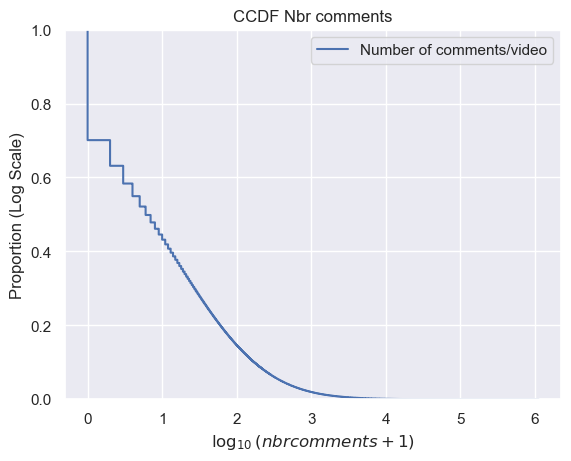

In [9]:
# Visual analysis using seaborn ccdf function
sns.ecdfplot(np.log10(num_comments.num_comms + 1), label="Number of comments/video", complementary=True)
plt.legend()
plt.xlabel(r'$\log_{10}(nbrcomments + 1)$')
plt.ylabel("Proportion (Log Scale)")
plt.title("CCDF Nbr comments")
plt.show()

- Add a ccdf plot but as the distribution is crushed by the large amount of small values this plot is intuitive.

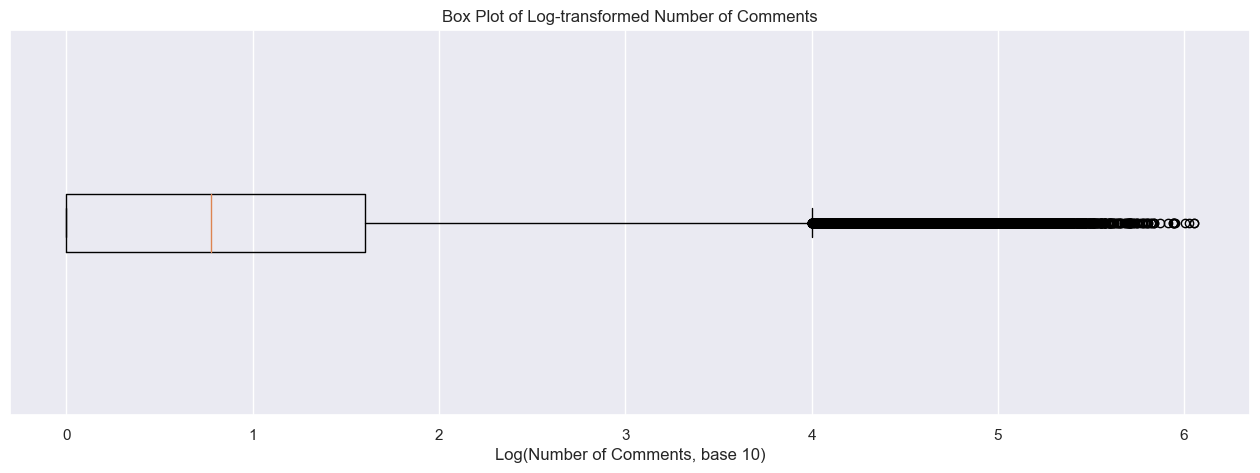

In [23]:
# Visual invistigation of the outliers
fig, ax = plt.subplots(figsize=(16, 5))

# Create the box plot with data transformation and hiding outliers
ax.boxplot(np.log10(num_comments.num_comms + 1), showfliers=True, vert=False)

# Customize the plot
ax.set_yticks([])
ax.set_xlabel("Log(Number of Comments, base 10)")
ax.set_title("Box Plot of Log-transformed Number of Comments")

# Show the plot
plt.show()

- Lets see the number of videos with number of comments above $10^4$

In [24]:
num_videos_with_more_than_10k_comments = len(num_comments[num_comments['num_comms'] > 1e4])

print(f"Number of videos with more than 10,000 comments: {num_videos_with_more_than_10k_comments}")

Number of videos with more than 10,000 comments: 83304


> Which result in at least 800 millions comments in total but not enough videos and we could inspect their categories but they certainly come from all the same category => music(e.g Luis Fonsi - Despacito ft. Daddy Yankee got 4millions comments).

In [26]:
num_videos_with_more_than_30_comments = len(num_comments[num_comments['num_comms'] > 30])

print(f"Number of videos with more than 30 comments: {num_videos_with_more_than_30_comments}")

Number of videos with more than 30 comments: 15940203


> Like in the paper and after further invistigation on youtube comments section we approve the fact that keeping the videos with at least 30 comments is a good threshold as a videos with 50 comments may produce 50k views which is good. 

> A good research would be to look how the categories the views and num of comments are related.

### 2. Authors comments dataset

In [27]:
num_comments_authors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 448810483 entries, 0 to 448810482
Data columns (total 2 columns):
 #   Column    Dtype
---  ------    -----
 0   author    int64
 1   video_id  int64
dtypes: int64(2)
memory usage: 6.7 GB


> video_id to refer as the numer of comments doesn't have much sense lets replace it simply by "number_comm"

In [12]:
num_comments_authors.describe()

,author,video_id
count,4.488105e+08,4.488105e+08
mean,2.882777e+08,1.917428e+01
std,1.664337e+08,1.406534e+02
min,1.000000e+00,1.000000e+00
25%,1.441397e+08,1.000000e+00
50%,2.882794e+08,2.000000e+00
75%,4.324085e+08,8.000000e+00
max,5.765520e+08,3.520200e+05


In [2]:
sorted_df = pd.read_parquet('data/num_comments_authors_sorted.parquet')

In [3]:
sorted_df = sorted_df.rename(columns={'video_id': 'number_comm'})

In [4]:
sorted_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 448810483 entries, 0 to 448810482
Data columns (total 2 columns):
 #   Column       Dtype
---  ------       -----
 0   author       int64
 1   number_comm  int64
dtypes: int64(2)
memory usage: 6.7 GB


In [38]:
sorted_df.head()

,author,number_comm
0,157898414,352020
1,309188934,285379
2,133567048,255775
3,472447001,202561
4,224828975,193858


> Like we did previously lets look at the distribution of the data

/var/folders/gx/b0gl84xd4rjflbpgs2bhddcc0000gp/T/ipykernel_85559/2885305410.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.log10(sorted_df.number_comm + 1), kde=False,


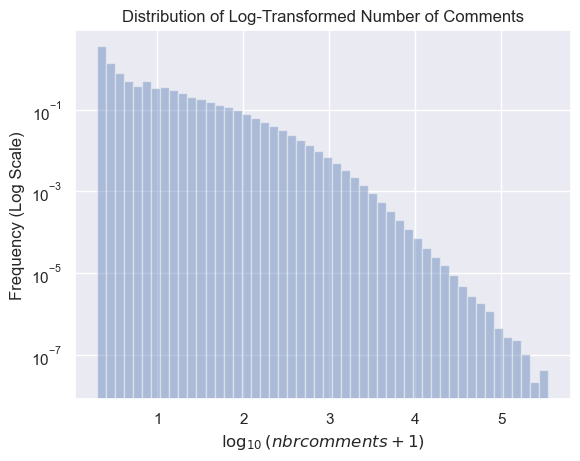

In [5]:
# Simple log log hist plot
kwargs = {'cumulative': False}
sns.distplot(np.log10(sorted_df.number_comm + 1), kde=False, 
             kde_kws=kwargs, norm_hist=True)
plt.title("Distribution of Log-Transformed Number of Comments")
plt.xlabel(r'$\log_{10}(nbrcomments + 1)$')
plt.ylabel("Frequency (Log Scale)")
plt.yscale('log')
plt.show()

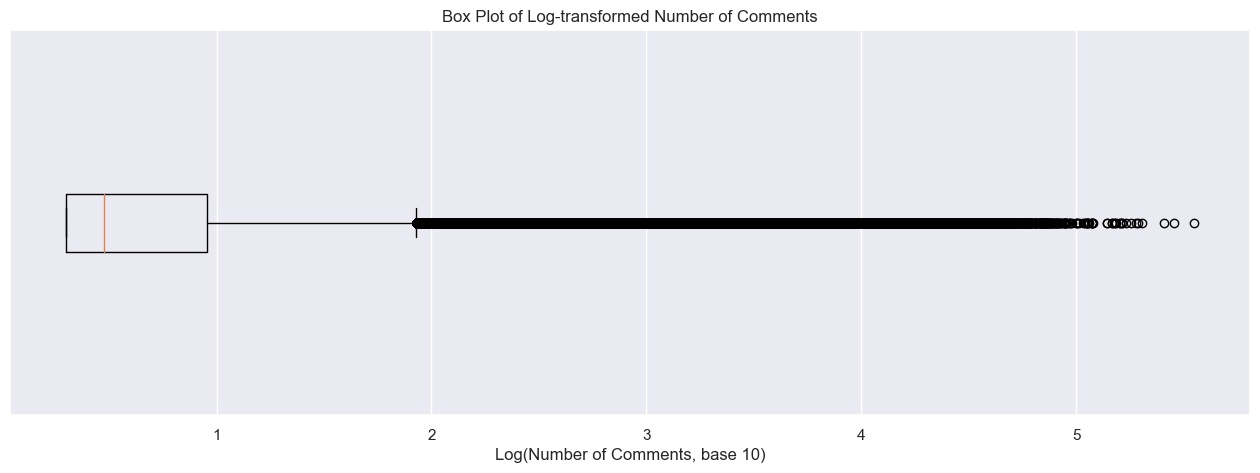

In [6]:
# Visual invistigation of the outliers
fig, ax = plt.subplots(figsize=(16, 5))

# Create the box plot with data transformation and hiding outliers
box = ax.boxplot(np.log10(sorted_df.number_comm + 1), showfliers=True, vert=False)

# Customize the plot
ax.set_yticks([])
ax.set_xlabel("Log(Number of Comments, base 10)")
ax.set_title("Box Plot of Log-transformed Number of Comments")

# Show the plot
plt.show()

> Here the analysis of the outliers is more interesting. First we can observe that some small group of authors are out on high values (note that in our case as we are using a log scale a small space between points represent a big gap). Moreover the boundary of the flyers on the box plot is lower than what we had with the video. Lets count the number of authors that are represented as flyers, there number of comments (descibe())

In [29]:
# Extract the fliers
fliers = [10**f.get_xdata() for f in box['fliers']][0]
heavy_authors = pd.DataFrame({'num_comms': fliers})

In [30]:
heavy_authors.describe()

,num_comms
count,1.829860e+07
mean,2.988613e+02
std,6.327638e+02
min,8.600000e+01
25%,1.130000e+02
50%,1.640000e+02
75%,2.910000e+02
max,3.520210e+05


In [31]:
heavy_authors.num_comms.sum()

5468744612.0

In [40]:
top_1million = heavy_authors.head(1000000)

In [41]:
top_1million.num_comms.sum()

1763726159.0

> We are still with a large amount of comments more than 5billions.

In [32]:
heavy_authors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18298605 entries, 0 to 18298604
Data columns (total 1 columns):
 #   Column     Dtype  
---  ------     -----  
 0   num_comms  float64
dtypes: float64(1)
memory usage: 139.6 MB


In [33]:
len(heavy_authors)

18298605

In [34]:
top_commenters = sorted_df.head(len(heavy_authors))
top_commenters.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18298605 entries, 0 to 18298604
Data columns (total 2 columns):
 #   Column       Dtype
---  ------       -----
 0   author       int64
 1   number_comm  int64
dtypes: int64(2)
memory usage: 279.2 MB


In [37]:
# save the top commenters
top_commenters.to_parquet(path='data/top_commenters.parquet')

> The outliers correspond to 18millions authors which is small in comparison to the 449millions (4% of all the authors), but for our analysis as we want to analyse communities it makes sense to restrict our self to these 18millions users that are the one that comments more so tend to be more active in a communities than authors that just comments once.

/var/folders/gx/b0gl84xd4rjflbpgs2bhddcc0000gp/T/ipykernel_59640/1761025676.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.log10(heavy_authors.num_comms + 1), kde=False,


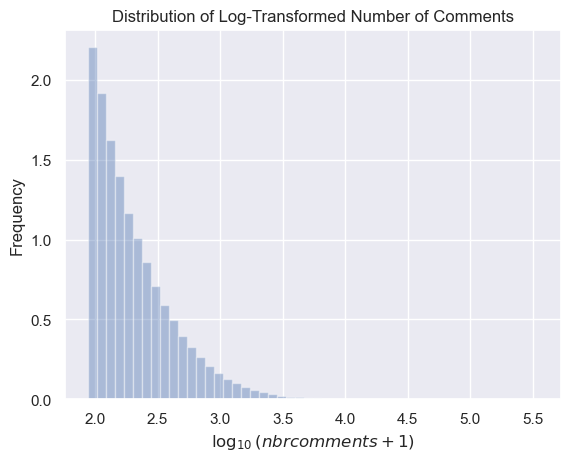

In [24]:
# Simple log log hist plot
kwargs = {'cumulative': False}
sns.distplot(np.log10(heavy_authors.num_comms + 1), kde=False, 
             kde_kws=kwargs, norm_hist=True)
plt.title("Distribution of Log-Transformed Number of Comments")
plt.xlabel(r'$\log_{10}(nbrcomments + 1)$')
plt.ylabel("Frequency")
# plt.y/scale('log')
plt.show()

> Continuation of the research: take the general comments_df, filter only the 18 millions authors highlighted previously, invistigate users with extreme nbr of comment (more than 10k) to keep only real user and avoir possible bots comments, then build using yt_metadata a df that combine these authors with the videos they commented on, but before we have to reduce the number of comments we have either by filtering the videos that we will use and drop all related comments or reduce the size of authors.